# Inspect the BN parameters are merged or not

In [ ]:
import torch, time

state_b1 = torch.load('./host_data/output/debug_dir/checkpoint_before_sync_e0_iter200.pth.tar')
print(state_b1.keys())
print(time.asctime(time.gmtime(float(state_b1['saving_time']))))

state_a1 = torch.load('./host_data/output/debug_dir/checkpoint_after_sync_e0_iter200.pth.tar')
print(state_a1.keys())
print(time.asctime(time.gmtime(float(state_a1['saving_time']))))

state_b2 = torch.load('./host_data/output/debug_dir2/checkpoint_before_sync_e0_iter200.pth.tar')
print(state_b2.keys())
print(time.asctime(time.gmtime(float(state_b2['saving_time']))))

state_a2 = torch.load('./host_data/output/debug_dir2/checkpoint_after_sync_e0_iter200.pth.tar')
print(state_a2.keys())
print(time.asctime(time.gmtime(float(state_a2['saving_time']))))

In [83]:
def compare_params(ref, target):
    a = [True]
    for n, params, in ref['model_state_dict'].items():
        s1 = params.cpu()
        s2 = taget['model_state_dict'][n].cpu()
        a.extend([np.allclose(s1, s2)])
        print(n, np.allclose(s1, s2))
    print(np.all(a))

print()
print('Compare both host checkpoints before SL merge.')
display(compare_params(state_b1, state_b2))

print('Compare single host checkpoints before and after SL merge.')
display(compare_params(state_b1, state_a1))

print('Compare both host checkpoints after SL merge.')
display(compare_params(state_a1, state_a2))


Compare both host checkpoints before SL merge.
features.conv0.weight False
features.norm0.weight False
features.norm0.bias False
features.norm0.running_mean False
features.norm0.running_var False
features.norm0.num_batches_tracked True
features.denseblock1.denselayer1.norm1.weight False
features.denseblock1.denselayer1.norm1.bias False
features.denseblock1.denselayer1.norm1.running_mean False
features.denseblock1.denselayer1.norm1.running_var False
features.denseblock1.denselayer1.norm1.num_batches_tracked True
features.denseblock1.denselayer1.conv1.weight False
features.denseblock1.denselayer1.norm2.weight False
features.denseblock1.denselayer1.norm2.bias False
features.denseblock1.denselayer1.norm2.running_mean False
features.denseblock1.denselayer1.norm2.running_var False
features.denseblock1.denselayer1.norm2.num_batches_tracked True
features.denseblock1.denselayer1.conv2.weight False
features.denseblock1.denselayer2.norm1.weight False
features.denseblock1.denselayer2.norm1.bias F

None

Compare single host checkpoints before and after SL merge.
features.conv0.weight False
features.norm0.weight False
features.norm0.bias False
features.norm0.running_mean False
features.norm0.running_var False
features.norm0.num_batches_tracked True
features.denseblock1.denselayer1.norm1.weight False
features.denseblock1.denselayer1.norm1.bias False
features.denseblock1.denselayer1.norm1.running_mean False
features.denseblock1.denselayer1.norm1.running_var False
features.denseblock1.denselayer1.norm1.num_batches_tracked True
features.denseblock1.denselayer1.conv1.weight False
features.denseblock1.denselayer1.norm2.weight False
features.denseblock1.denselayer1.norm2.bias False
features.denseblock1.denselayer1.norm2.running_mean False
features.denseblock1.denselayer1.norm2.running_var False
features.denseblock1.denselayer1.norm2.num_batches_tracked True
features.denseblock1.denselayer1.conv2.weight False
features.denseblock1.denselayer2.norm1.weight False
features.denseblock1.denselayer2.n

None

Compare both host checkpoints after SL merge.
features.conv0.weight True
features.norm0.weight True
features.norm0.bias True
features.norm0.running_mean True
features.norm0.running_var True
features.norm0.num_batches_tracked True
features.denseblock1.denselayer1.norm1.weight True
features.denseblock1.denselayer1.norm1.bias True
features.denseblock1.denselayer1.norm1.running_mean True
features.denseblock1.denselayer1.norm1.running_var True
features.denseblock1.denselayer1.norm1.num_batches_tracked True
features.denseblock1.denselayer1.conv1.weight True
features.denseblock1.denselayer1.norm2.weight True
features.denseblock1.denselayer1.norm2.bias True
features.denseblock1.denselayer1.norm2.running_mean True
features.denseblock1.denselayer1.norm2.running_var True
features.denseblock1.denselayer1.norm2.num_batches_tracked True
features.denseblock1.denselayer1.conv2.weight True
features.denseblock1.denselayer2.norm1.weight True
features.denseblock1.denselayer2.norm1.bias True
features.dense

None

# Analyze the data for Splitting Among SL nodes

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [93]:
train_set = pd.read_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/train.csv')
#train_set.rename(columns={'Pleural Effusion':'Effusion'}, inplace=True)
display('original train_set',train_set.head())
print()

val_set = pd.read_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/valid.csv')
#val_set.rename(columns={'Pleural Effusion':'Effusion'}, inplace=True)
display('original val_set', val_set.head())
print()

'original train_set'

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


'original val_set'

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


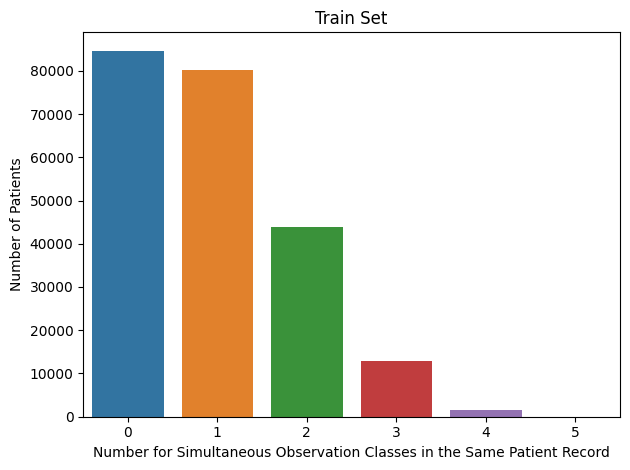

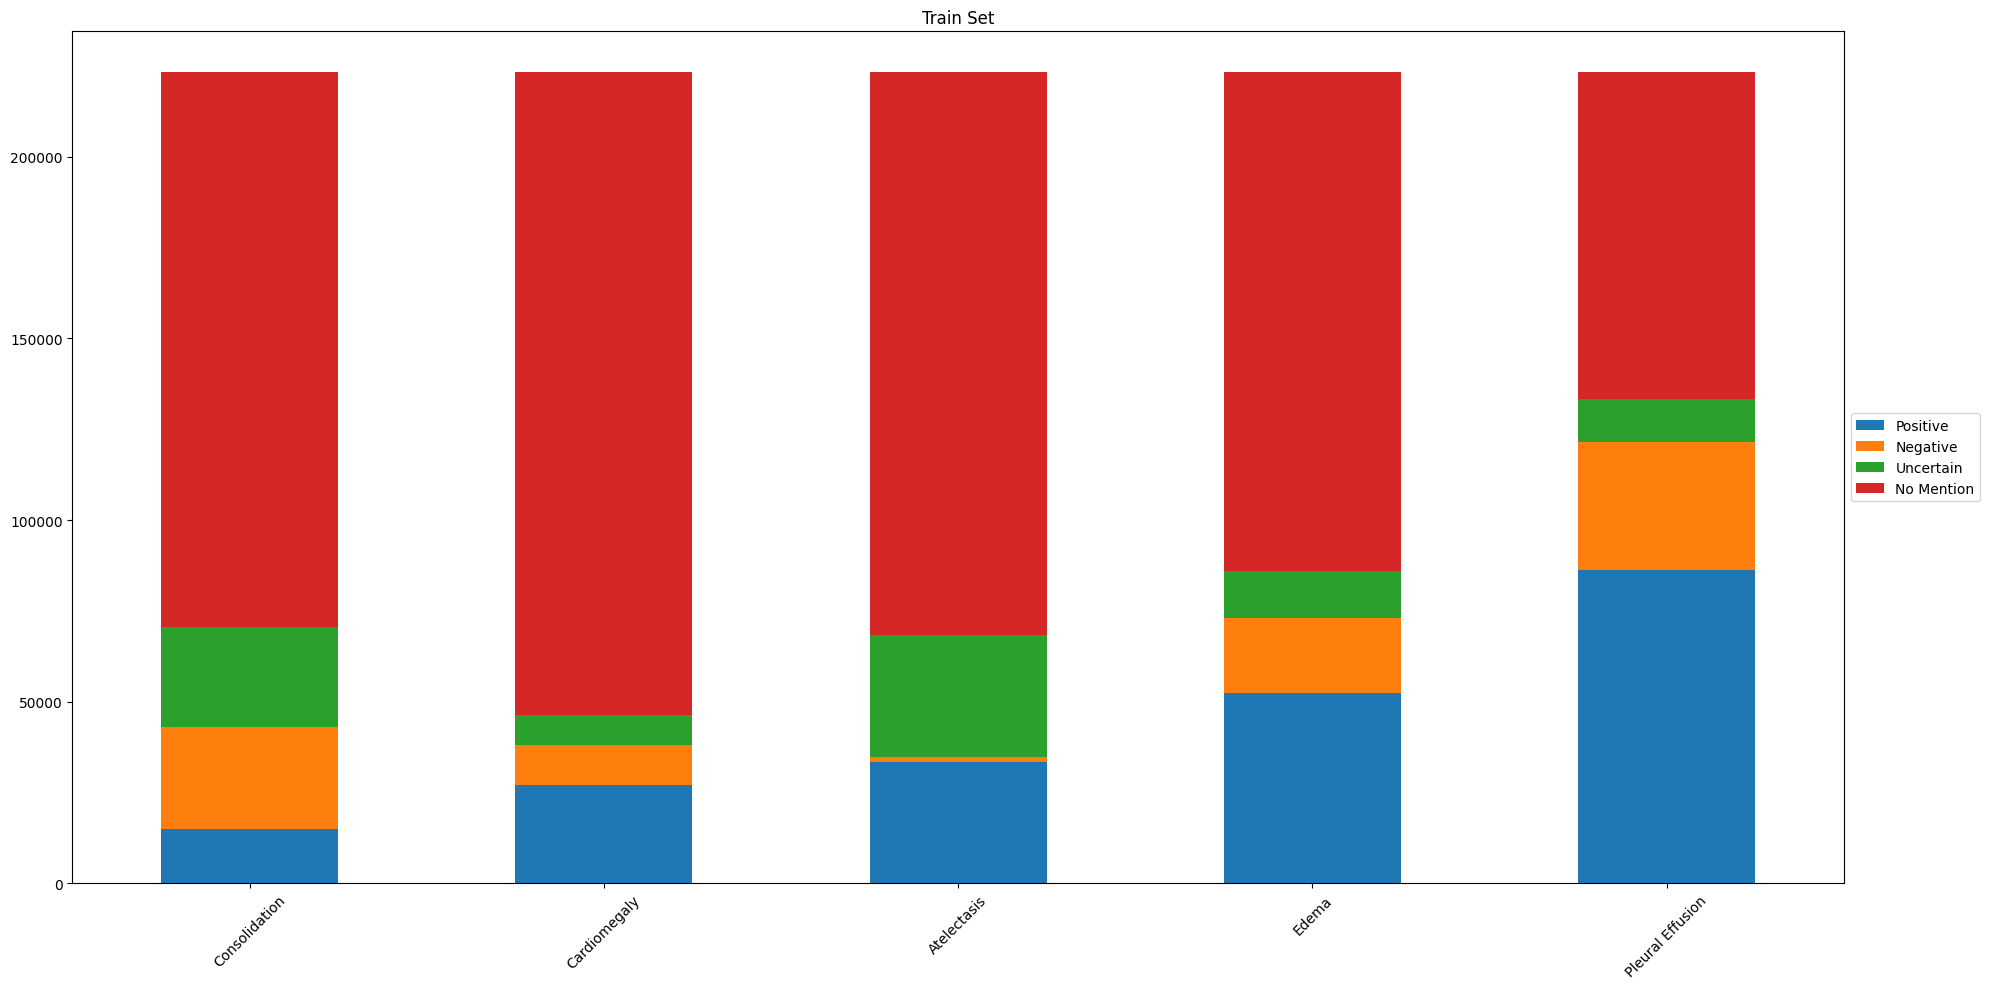

,Positive,Negative,Uncertain,No Mention
Cardiomegaly,27000,11116,8087,177211
Edema,52246,20726,12984,137458
Consolidation,14783,28097,27742,152792
Atelectasis,33376,1328,33739,154971
Pleural Effusion,86187,35396,11628,90203


In [159]:
# Training Set Distribution
all_classes = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
all_classes = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']

train_set_disease = train_set.loc[:,all_classes].fillna(-2).astype(np.int8)

temp1 = (train_set_disease==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()


m1=(train_set_disease==1).sum(axis=0)
m0=(train_set_disease==0).sum(axis=0)
mu=(train_set_disease==-1).sum(axis=0)
mna=(train_set_disease==-2).sum(axis=0)
train_set_disease_summary = pd.DataFrame([m1, m0, mu, mna]).transpose()
train_set_disease_summary.columns=['Positive','Negative', 'Uncertain', 'No Mention']
axes = train_set_disease_summary.sort_values(["Positive","Negative"]).plot(kind='bar', figsize=(20,10), stacked=True, rot=45)
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#train_set_disease_summary.iloc[:,:3].plot(kind='bar', figsize=(20,10))
plt.tick_params('x', labelrotation=45)
plt.title("Train Set")
plt.tight_layout()
plt.show()

display(train_set_disease_summary)

In validation set, 35.8974358974359% are multilabel patient.
In validation set, 41.452991452991455% are multilabel patient.
In validation set, 22.64957264957265% are multilabel patient.


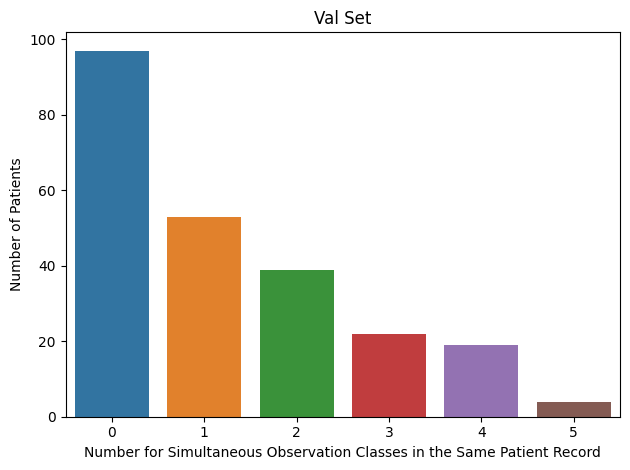

,Positive,Negative
Consolidation,33,201
Edema,45,189
Pleural Effusion,67,167
Cardiomegaly,68,166
Atelectasis,80,154


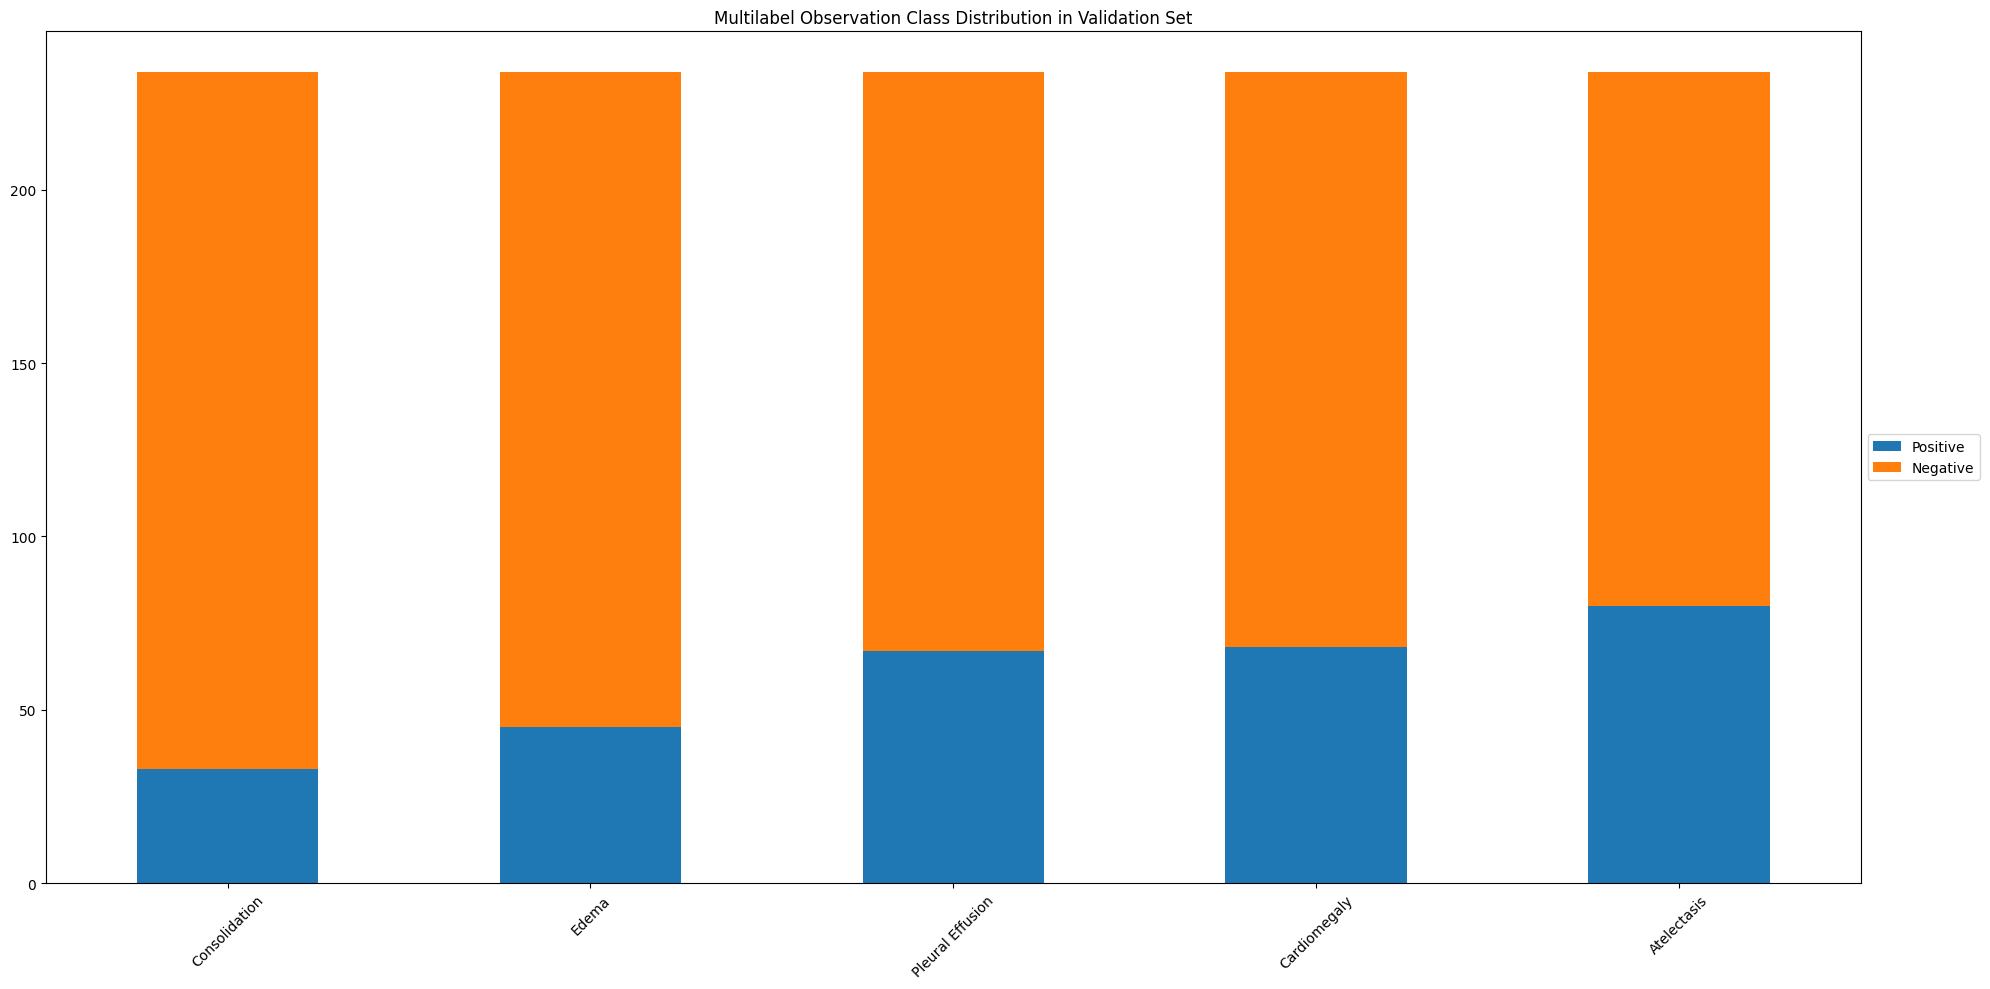

In [162]:
# Val Set Distribution

val_set_disease = val_set.loc[:,all_classes].fillna(-2).astype(np.int8)

temp_acc = 0
temp = (val_set.loc[:,all_classes].sum(axis=1)>1.5).sum()/val_set.shape[0]
print("In validation set, {}% are multilabel patient.".format(temp*100))
temp_acc=temp

temp = (val_set.loc[:,all_classes].sum(axis=1)<0.1).sum()/val_set.shape[0]
print("In validation set, {}% are multilabel patient.".format(temp*100))
temp_acc = temp_acc + temp

temp = (val_set.loc[:,all_classes].sum(axis=1)==1.0).sum()/val_set.shape[0]
print("In validation set, {}% are multilabel patient.".format(temp*100))
temp_acc = temp_acc + temp

assert int(temp_acc*100) == int(100)

temp = val_set_disease.loc[:,all_classes].sum(axis=1)
sns.countplot(temp.to_frame(), x=0)
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.title("Val Set")
plt.tight_layout()
plt.show()

# display(val_set_disease.sum().sort_values())
# ax = val_set_disease.sum().sort_values().plot(kind='bar',rot=45, figsize=(20,10), title="Multilabel Observation Class Distribution in Validation Set")
# ax.set_ylabel('Count')
# plt.show()

temp1=(val_set.loc[:,all_classes]==1).sum().sort_values()
temp2=(val_set.loc[:,all_classes]==0).sum()
temp=pd.DataFrame({"1":temp1, "0":temp2}).sort_values("1")
temp.columns = ['Positive','Negative']
display(temp)
axes = temp.plot(kind='bar', rot=45, figsize=(20,10), stacked=True, title="Multilabel Observation Class Distribution in Validation Set")
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


# plt.figure(figsize=(20,10))
# aa = temp.reset_index()
# aa = aa.melt(id_vars='index')
# axs = sns.barplot(data=aa, x='index', y='value', hue='variable')
# axs.tick_params(axis='x', labelrotation=45)

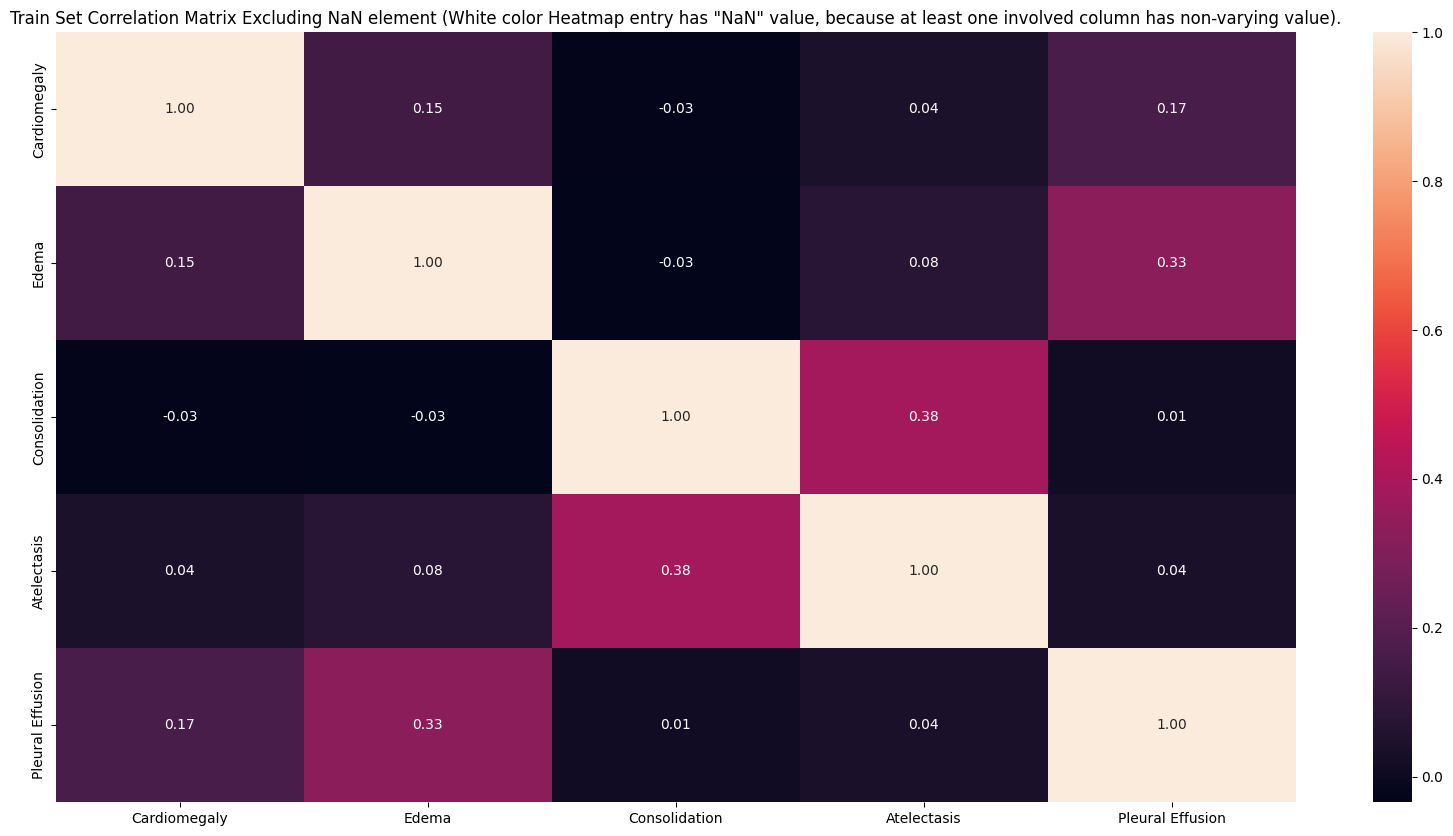

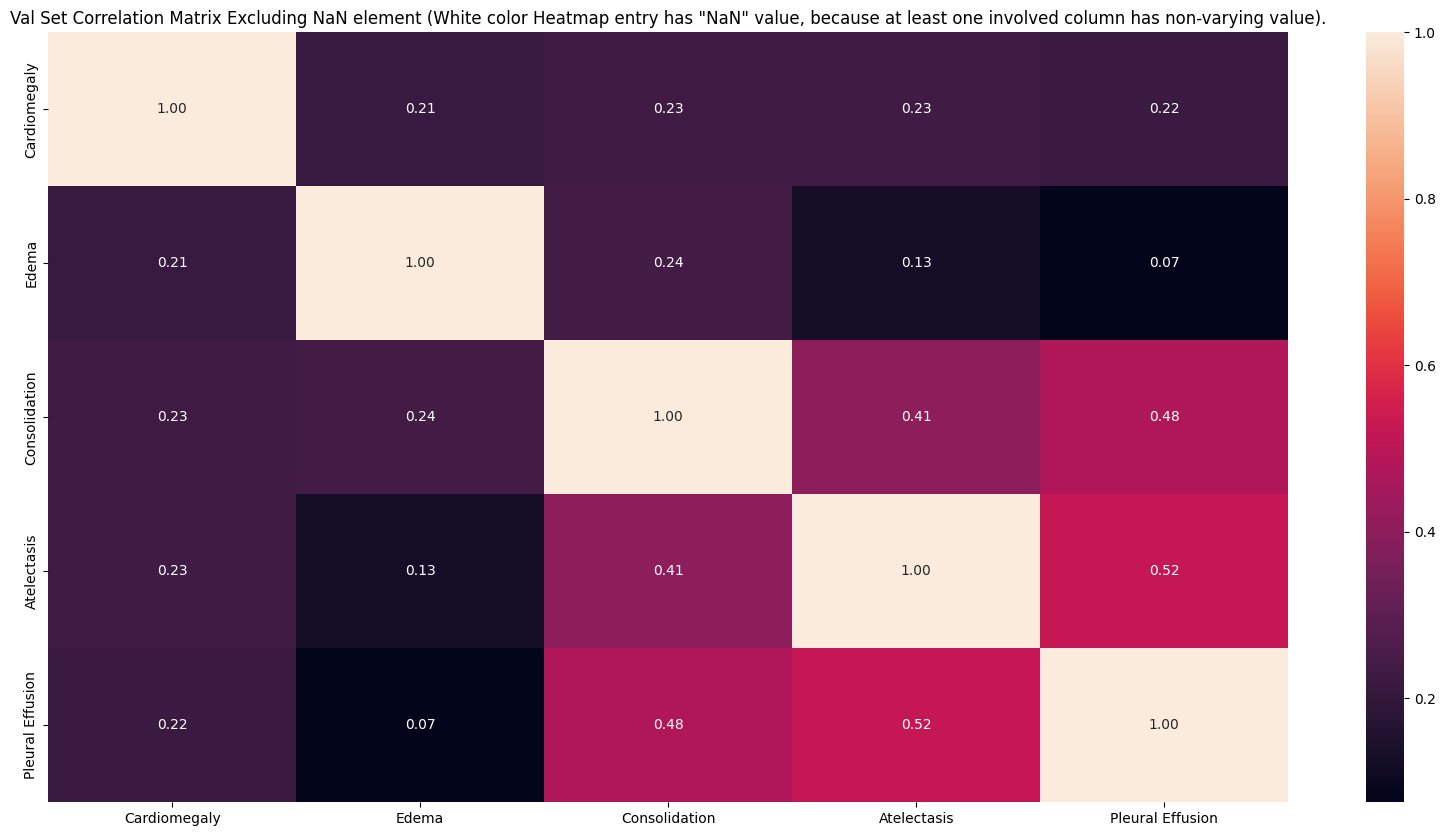

In [104]:
# Inspect co-occurance
train_set_disease_temp = train_set.loc[:,all_classes]
plt.figure(figsize=(20,10))
sns.heatmap(train_set_disease_temp.corr(numeric_only=False), annot=True, fmt=".2f")
plt.title('Train Set Correlation Matrix Excluding NaN element (White color Heatmap entry has "NaN" value, because at least one involved column has non-varying value).')
plt.show()

val_set_disease_temp = val_set.loc[:,all_classes]
plt.figure(figsize=(20,10))
sns.heatmap(val_set_disease_temp.corr(numeric_only=False), annot=True, fmt=".2f")
plt.title('Val Set Correlation Matrix Excluding NaN element (White color Heatmap entry has "NaN" value, because at least one involved column has non-varying value).')
plt.show()


In [109]:
from model.src.dataloader_robust import CheXpert
import os

In [112]:
root = "/tmp/test/workspace_lung_disease/sl_version/host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small"
train_cols = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']
traindSet  = CheXpert(csv_path=os.path.join(root,'train.csv'), image_root_path=root, use_upsampling=False, use_frontal=True, image_size=320, mode='train', class_index=-1, shuffle=False, seed=123)

/tmp/test/workspace_lung_disease/sl_version/model/src/dataloader_robust.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0-small/', '')
/tmp/test/workspace_lung_disease/sl_version/model/src/dataloader_robust.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0/', '')


Multi-label mode: True, Number of classes: [5]
------------------------------
Found 191027 images in total, 23385 positive images, 167642 negative images
Cardiomegaly(C0): imbalance ratio is 0.1224

Found 191027 images in total, 61493 positive images, 129534 negative images
Edema(C1): imbalance ratio is 0.3219

Found 191027 images in total, 12983 positive images, 178044 negative images
Consolidation(C2): imbalance ratio is 0.0680

Found 191027 images in total, 59583 positive images, 131444 negative images
Atelectasis(C3): imbalance ratio is 0.3119

Found 191027 images in total, 76899 positive images, 114128 negative images
Pleural Effusion(C4): imbalance ratio is 0.4026

------------------------------


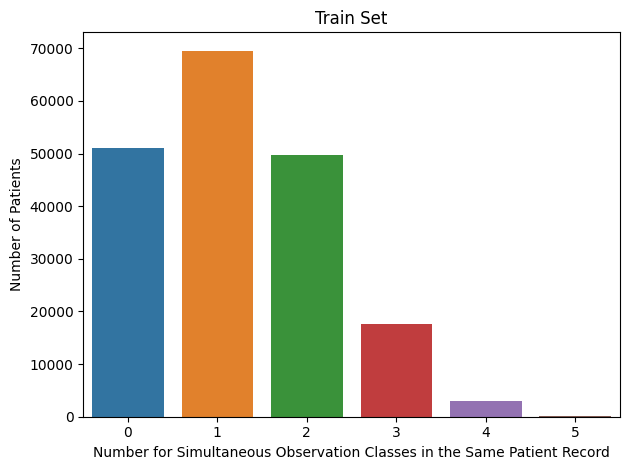

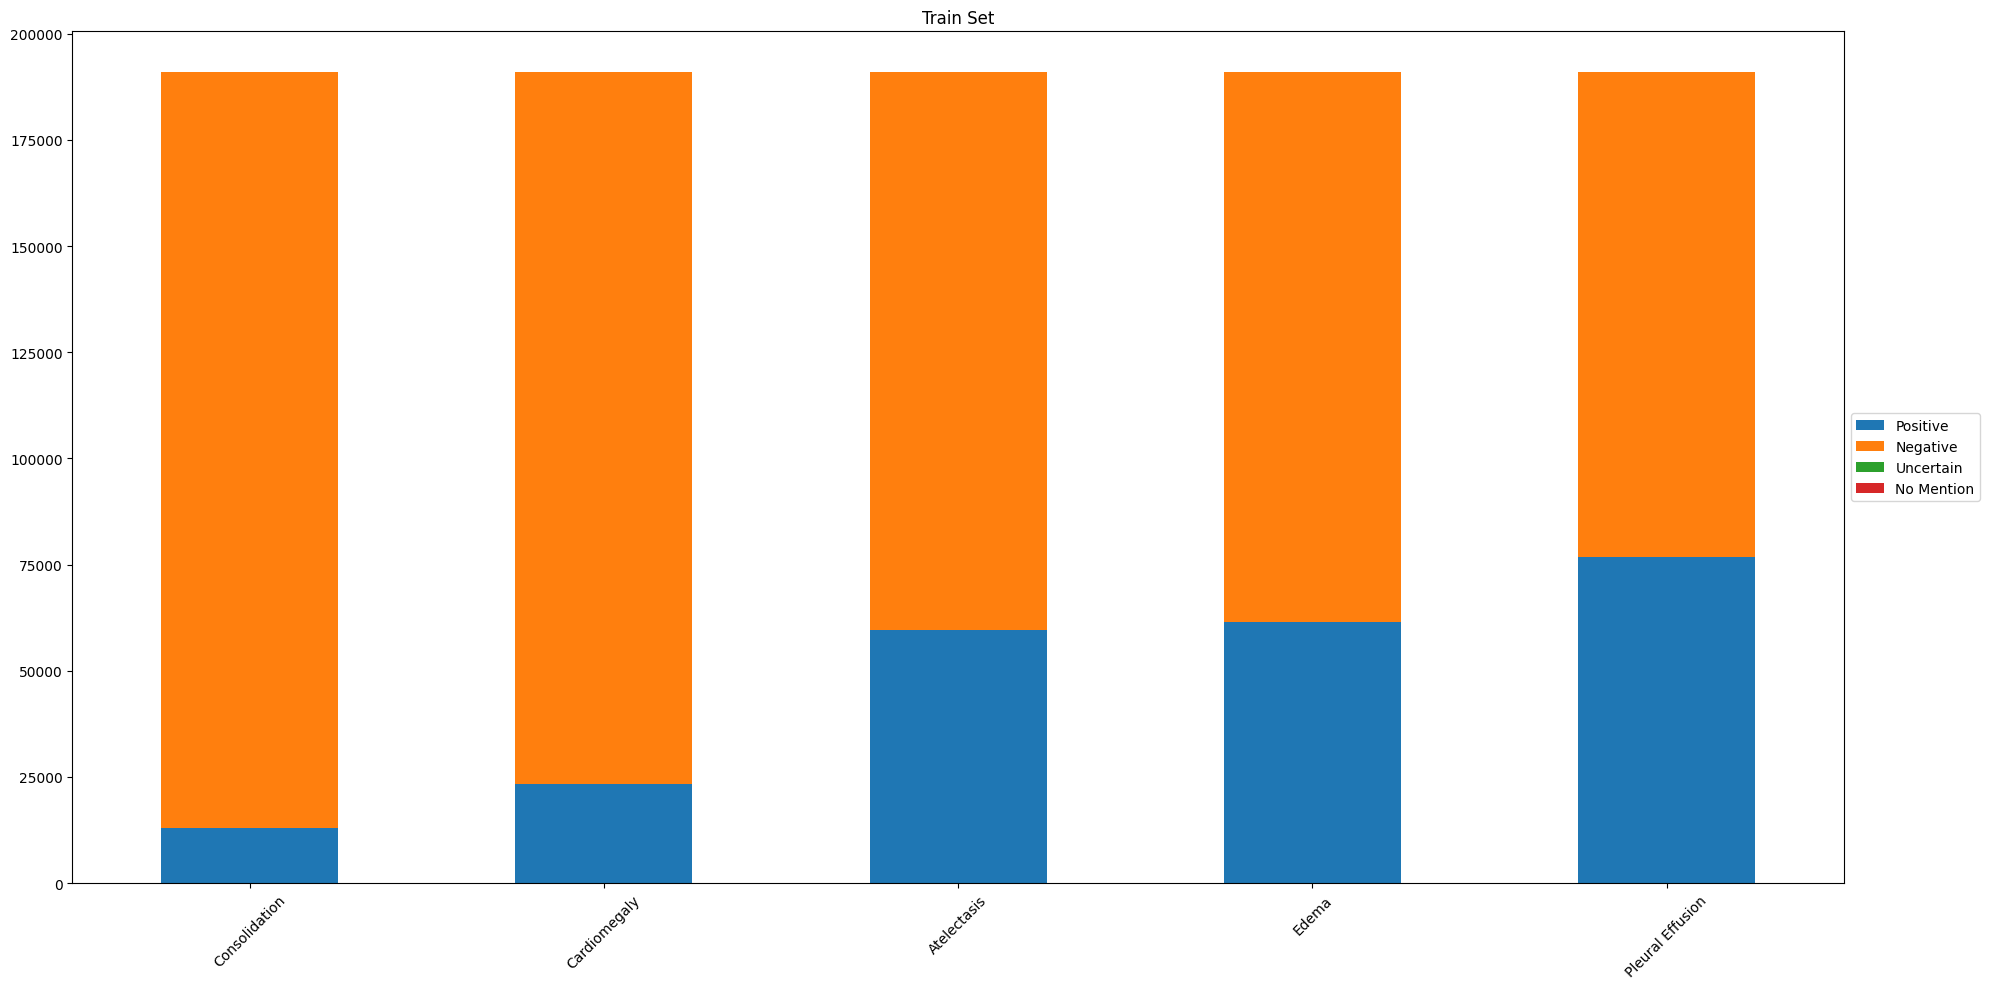

In [329]:
# Training Set Distribution

train_set_disease = traindSet.df.loc[:,all_classes].astype(np.int8)

temp1 = (train_set_disease==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()

m1=(train_set_disease==1).sum(axis=0)
m0=(train_set_disease==0).sum(axis=0)
mu=(train_set_disease==-1).sum(axis=0)
mna=(train_set_disease==-2).sum(axis=0)
train_set_disease_summary = pd.DataFrame([m1, m0, mu, mna]).transpose()
train_set_disease_summary.columns=['Positive','Negative', 'Uncertain', 'No Mention']
axes = train_set_disease_summary.sort_values(["Positive","Negative"]).plot(kind='bar', figsize=(20,10), stacked=True, rot=45)
axes.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
#train_set_disease_summary.iloc[:,:3].plot(kind='bar', figsize=(20,10))
plt.tick_params('x', labelrotation=45)
plt.title("Train Set")
plt.tight_layout()
plt.show()

# display(train_set_disease_summary)
# d=True, rot=45)
# axes.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
# #train_set_disease_summary.iloc[:,:3].plot(kind='bar', figsize=(20,10))
# plt.tick_params('x', labelrotation=45)
# plt.title("Train Set")
# plt.tight_layout()
# plt.show()

#display(train_set_disease_summary)


In [422]:
import copy
display(train_cols )
host1_ratio = [0.8, 0.8, 0.8, 0.15, 0.6]


def f1(df, col, ratio, offset=0):
    temp1 = df.loc[:,col]
    temp2 = temp1.loc[temp1==1]
    if offset >= temp2.shape[0]*ratio:
        print('skip f1 because offset={}'.format(offset))
        return []
    else:
        temp3 = np.random.choice(temp2.shape[0], int(temp2.shape[0]*ratio) - offset, replace=False)
        index2 = temp2.iloc[temp3].index
        print(index2.shape[0]/temp2.shape[0])
        return index2

display(train_set_disease.sum())
dfx = copy.deepcopy(train_set_disease)
dfy = None
indices = []
for col, ratio in zip(train_cols, host1_ratio):
    print('#################################################')
    print('#################################################')

    if dfx.shape[0] == train_set_disease.shape[0]:
        already_have=0
    else:
        already_have = int(dfy.loc[:,col].sum())
        print('already_have:', already_have)

    if dfy is not None:
        print(dfy.sum(axis=0))
    print(already_have)
    index = list(np.array(f1(dfx, col, ratio, offset=already_have)))
    indices.extend(index)

    dfy = copy.deepcopy(train_set_disease.loc[train_set_disease.index.isin(indices),:])
    mask = ~dfx.index.isin(index)
    dfx = dfx.iloc[mask,:]
    print(col, ratio, len(index))
    print('#################################################')


print('#################################################')
print('#################################################')
display(dfy.sum())
display(train_set_disease.loc[indices].sum())
display(max(indices))

print('#################################################')
print('#################################################')
mask = train_set_disease.loc[:,train_cols].sum(axis=1)<0.5
display(mask.sum())
temp2 = train_set_disease.loc[mask,:]
temp3 = np.random.choice(temp2.shape[0], int(temp2.shape[0]*0.5), replace=False)
index2 = temp2.iloc[temp3].index
indices.extend(list(index2))

print('#################################################')
print('#################################################')
display(train_set_disease.loc[indices].sum())


['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

Cardiomegaly        23385
Edema               61493
Consolidation       12983
Atelectasis         59583
Pleural Effusion    76899
dtype: int64

#################################################
#################################################
0
0.8
Cardiomegaly 0.8 18708
#################################################
#################################################
#################################################
already_have: 10113
Cardiomegaly        18708
Edema               10113
Consolidation        1006
Atelectasis          5727
Pleural Effusion     8355
dtype: int64
10113
0.6031724406383807
Edema 0.8 30991
#################################################
#################################################
#################################################
already_have: 2945
Cardiomegaly        20239
Edema               41104
Consolidation        2945
Atelectasis         15448
Pleural Effusion    22761
dtype: int64
2945
0.5065750149432158
Consolidation 0.8 5085
#################################################
#################################################
#################################################
already_

Cardiomegaly        20465
Edema               42760
Consolidation        8316
Atelectasis         19003
Pleural Effusion    31005
dtype: int64

Cardiomegaly        20465
Edema               42760
Consolidation        8316
Atelectasis         19003
Pleural Effusion    31005
dtype: int64

223412

#################################################
#################################################


51052

#################################################
#################################################


Cardiomegaly        20465
Edema               42760
Consolidation        8316
Atelectasis         19003
Pleural Effusion    31005
dtype: int64

Cardiomegaly        20465.0
Edema               42760.0
Consolidation        8316.0
Atelectasis         19003.0
Pleural Effusion    31005.0
dtype: float64

Cardiomegaly         2920.0
Edema               18733.0
Consolidation        4667.0
Atelectasis         40580.0
Pleural Effusion    45894.0
dtype: float64

223412

191027

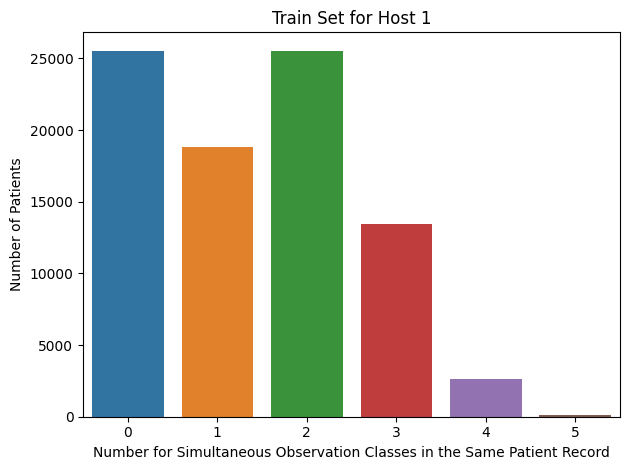

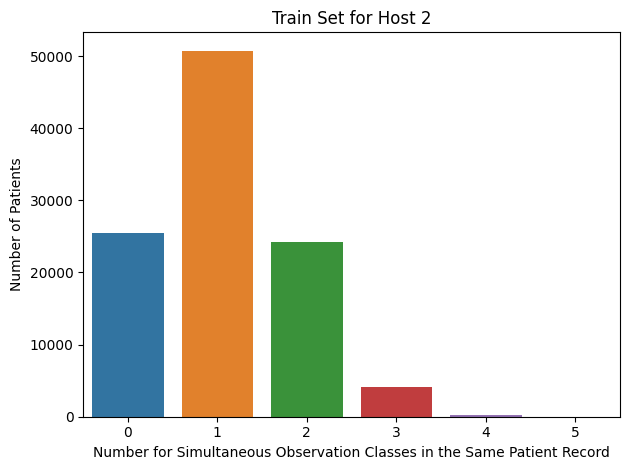

In [423]:
p1 = traindSet.df.loc[traindSet.df.index.isin(indices),:]
p2 = traindSet.df.loc[~traindSet.df.index.isin(indices),:]
p1.reset_index(inplace=True, drop=False)
p2.reset_index(inplace=True, drop=False)
assert (p1.loc[:,'index'].unique().shape[0] == p1.shape[0])
assert (p2.loc[:,'index'].unique().shape[0] == p2.shape[0])
p1.to_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/train_sl1.csv')
p2.to_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/train_sl1.csv')
p11 = p1.loc[:, train_cols]
p22 = p2.loc[:, train_cols]
display(p11.sum())
display(p22.sum())
display(max(indices))
display(p11.shape[0]+p22.shape[0])


temp1 = (p11==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set for Host 1")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()


temp1 = (p22==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set for Host 2")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()

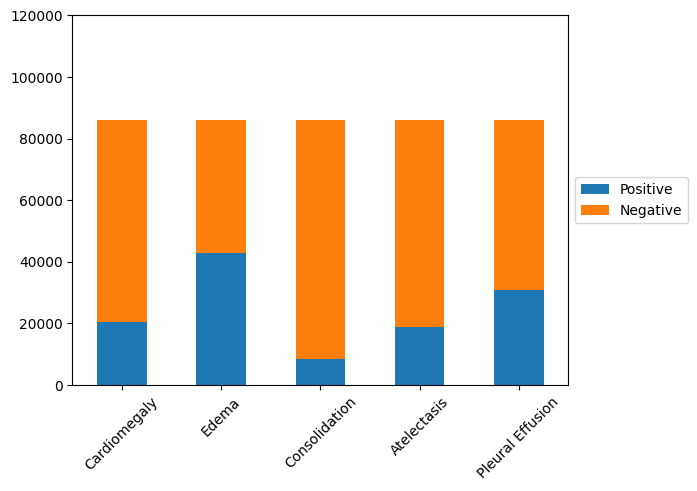

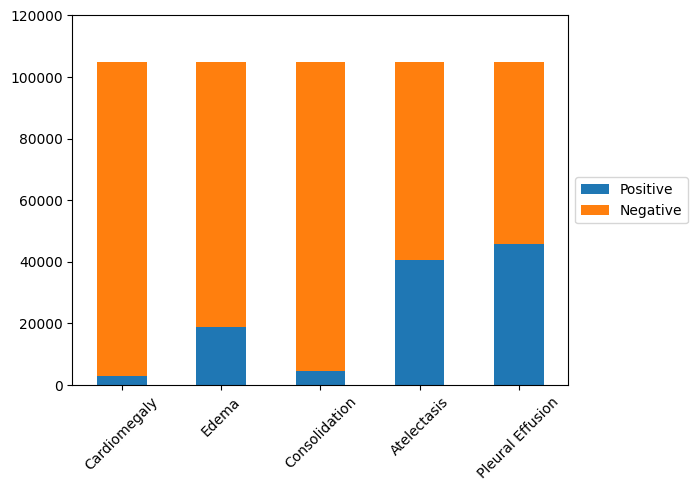

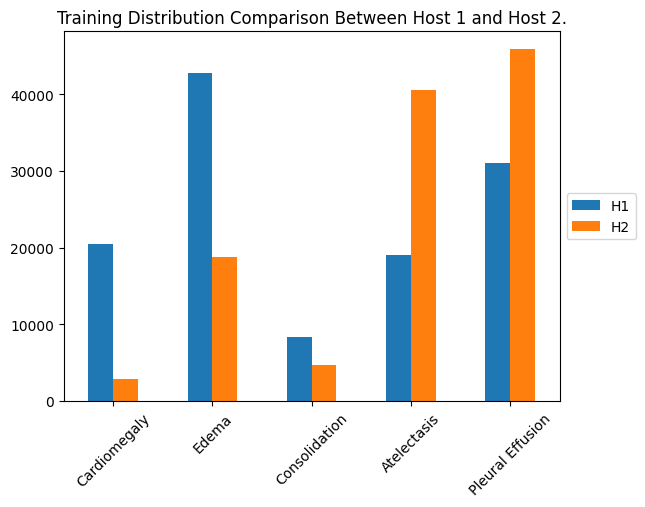

In [425]:
positive = p11.transpose().sum(axis=1)
negative = p11.transpose().shape[1] - positive
temp = pd.DataFrame(index=p11.transpose().index, data={'Positive': positive, 'Negative': negative})
axes = temp.plot(kind='bar', stacked=True, rot=45)
axes.set_ylim(ymin=0, ymax=120000)
axes.legend(loc='center left', bbox_to_anchor=[1.0,0.5])
temp1 = copy.deepcopy(temp)

positive = p22.transpose().sum(axis=1)
negative = p22.transpose().shape[1] - positive
temp = pd.DataFrame(index=p22.transpose().index, data={'Positive': positive, 'Negative': negative})
axes = temp.plot(kind='bar', stacked=True, rot=45)
axes.set_ylim(ymin=0, ymax=120000)
axes.legend(loc='center left', bbox_to_anchor=[1.0,0.5])

temp1.columns = ['H1', 'H2']
temp1.loc[:,'H2'] = temp['Positive']
axes = temp1.plot(kind='bar', stacked=False, rot=45)
plt.title('Training Distribution Comparison Between Host 1 and Host 2.')
axes.legend(loc='center left', bbox_to_anchor=[1.0,0.5])


In [ ]:
temp.plot.bar()